<a href="https://colab.research.google.com/github/Korck666/Notebooks/blob/main/monty_hall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

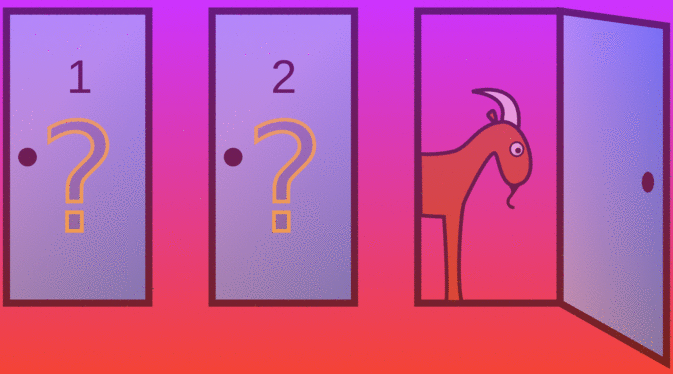
#[Monty Hall problem](https://en.wikipedia.org/wiki/Monty_Hall_problem)


---
### In search of a new car, the player picks a door, say 1. The game host then opens one of the other doors, say 3, to reveal a goat and offers to let the player switch from door 1 to door 2.


## Game rules
---
According to the rules of the game, among the various "***doors***," it is guaranteed that only one door will give access to the desired reward. The other doors will not.
> there are only 2 possibles outcomes from any door, the ***`prize`***, or a ***`goat`***;

> must have ONE and only one door with `prize`;

> `open`, `closed` and `player` are the possible states of a door; 

> all doors will be `closed` at the beginning;

> the game cannot `open` the `player`'s door.

> `prize` has a fixed frequency of `1/N`, where `N` is the number of the ***doors*** in the game.
>> when `2 > N > 2`, the game presents a *class imbalance* problem

>The game plays with a class imbalance in favors to the "***goat***" class
>>let's stipulate that `N > 2`.

In [38]:
#game rules
rules = {
    'outcomes':['prize', 'goat'],
    'must_have_one_and_only_one_outcome':'prize',
    'states':['open', 'closed', 'player'],
    'min_doors':3 #N > 2
}

###The Game algorithm:


1.   Define the number of the doors;
2.   Create all the doors with `goats` as outcome and `closed` state;
3.   Randomly change one of the door's outcome to `prize`;
4.   The player must randomly select one of the doors. Its state changes to `player`;
5.   The game **must `open` a door** with a `goat` outcome that is NOT the `player`'s door;
6.   Player may `switch` it's door. They states switches;
7.   If *only TWO doors* remains closed, the game is finished and the player takes the door's outcome;
8.   Go to step 5.




## Building the game
---

The game will implement a simple state machine that implements the algorithm:


> Every step will be translated to an action;

> The tupple (state, action, state) will determine possible transactions;

> States will represent the game data snapshot.


In [39]:
!pip install transitions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
from typing_extensions import ClassVar
from typing import Dict, List
from transitions import Machine
from pprint import pprint
import random

class MontyHallGame:
    verbose_mode = False

    # Define the verbose decorator 
    def verbose(func):
      def wrapper(*args, **kwargs):
        if MontyHallGame.verbose_mode:
          print(f"Calling function '{func.__name__}'")
        return func(*args, **kwargs)
      return wrapper

    states = ['start', 'player_turn', 'game_turn', 'end']
    transitions = [
        {   # player_turn => first door
            'trigger': 'player_choice',
            'source': 'start',
            'dest': 'player_turn',
            'before': 'chose_door',
        },
        {   # game_turn => open a goat door
            'trigger': 'open_door',
            'source': 'player_turn',
            'dest': 'game_turn',
            'before': 'reveal_goat_door',
            'conditions': 'has_3_or_more_closed',
        },
        {   # player_turn => will player switch doors?
            'trigger': 'player_choice',
            'source': 'game_turn',
            'dest': 'player_turn',
            'before': 'switch_door',
        },
        {   # end state => player win/lose
            'trigger': 'open_door',
            'source': 'player_turn',
            'dest': 'end',
            'before': 'reveal_prize_door',
            'unless': 'has_3_or_more_closed',
        },
    ]

    def __init__(self, rules: Dict, num_doors: int) -> None:

        self.num_doors = num_doors
        assert self.num_doors >= rules['min_doors']

        self.prize = rules['must_have_one_and_only_one_outcome']
        # drop the prize from outcome_list
        self.outcome_list = list(filter(lambda f: f != self.prize, rules['outcomes']))
        # initialize all doors with random outcome but prize and closed
        self.doors = [{'outcome': self.outcome_list[random.randint(0, len(self.outcome_list) - 1)], 'state': 'closed'} for _ in range(num_doors)]
        # randomly set one door as the prize one
        self.prize_door_index = random.randint(0, num_doors - 1)
        self.doors[self.prize_door_index]['outcome'] = 'prize'

        self.player_door_index = None

        # set the state machine
        self.machine = Machine(model=self, states=self.states, transitions=self.transitions, initial='start')

    @verbose
    def chose_door(self) -> None:
        self.player_door_index = random.randint(0, self.num_doors-1)
        if MontyHallGame.verbose_mode:
          print(f"You chose the door {self.player_door_index}.")

    @verbose
    def reveal_goat_door(self) -> None:
        closed_doors = [i for i, door in enumerate(self.doors) if door['state'] == 'closed']
        closed_doors.remove(self.player_door_index)
        if self.prize_door_index != self.player_door_index:
          closed_doors.remove(self.prize_door_index)
        self.open_door_index = random.choice(closed_doors)
        self.doors[self.open_door_index]['state'] = 'open'
        if MontyHallGame.verbose_mode:
          print(f"Door {self.open_door_index} has a goat behind it!")

    @verbose
    def switch_door(self, switch=True) -> None:
        if not switch:
          if MontyHallGame.verbose_mode:
            print(f"You kept door {self.player_door_index}.")
          return
        remaining_closed_doors = [i for i, door in enumerate(self.doors) if door['state'] == 'closed']
        remaining_closed_doors.remove(self.player_door_index)
        self.player_door_index = random.choice(remaining_closed_doors)
        if MontyHallGame.verbose_mode:
          print(f"You switched to door {self.player_door_index}.")

    @verbose
    def reveal_prize_door(self) -> bool:
        if self.doors[self.player_door_index]['outcome'] != 'prize':
          if MontyHallGame.verbose_mode:
            print("Sorry, you didn't win the prize.")
          return False
        if MontyHallGame.verbose_mode:
          print("Congratulations, you won the prize!")
        return True

    @verbose
    def has_3_or_more_closed(self) -> bool:
      closed_doors = [door for door in self.doors if door['state'] == 'closed']
      return len(closed_doors) >= 3



### Test the engine

In [49]:
game = MontyHallGame(rules, 3)
MontyHallGame.verbose_mode = True
pprint(game.doors)
while not game.is_end():
  game.player_choice()
  game.open_door()


[{'outcome': 'goat', 'state': 'closed'},
 {'outcome': 'goat', 'state': 'closed'},
 {'outcome': 'prize', 'state': 'closed'}]
Calling function 'chose_door'
You chose the door 0.
Calling function 'has_3_or_more_closed'
Calling function 'reveal_goat_door'
Door 1 has a goat behind it!
Calling function 'switch_door'
You switched to door 2.
Calling function 'has_3_or_more_closed'
Calling function 'has_3_or_more_closed'
Calling function 'reveal_prize_door'
Congratulations, you won the prize!
